In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from jmetal.core.algorithm import Algorithm
from jmetal.core.problem import FloatProblem, Problem
from jmetal.core.solution import FloatSolution
from typing import List
from pathlib import Path
import re
from collections import defaultdict

In [2]:
def ensure_dir(path: str):
    os.makedirs(path, exist_ok=True)


def log_to_csv(log: List[float], filename: str):
    pd.DataFrame({'objective': log}).to_csv(filename, index=False)


def plot_loss_curve(log: List[float], filename: str):
    plt.figure()
    plt.plot(log)
    plt.xlabel('Iteration')
    plt.ylabel('Objective Value')
    plt.title('Objective Value over Iterations')
    plt.grid(True)
    plt.savefig(filename)
    plt.close()

In [3]:
class Rosenbrock(FloatProblem):
    def __init__(self, number_of_variables: int = 10):
        self._number_of_variables = number_of_variables
        self._lower_bound = [-5.0] * number_of_variables
        self._upper_bound = [5.0] * number_of_variables
        self.obj_directions = [self.MINIMIZE]
        self.obj_labels = ["f(x)"]

    def number_of_variables(self) -> int:
        return self._number_of_variables

    def number_of_objectives(self) -> int:
        return 1

    def number_of_constraints(self) -> int:
        return 0

    @property
    def lower_bound(self):
        return self._lower_bound

    @property
    def upper_bound(self):
        return self._upper_bound

    def create_solution(self) -> FloatSolution:
        solution = FloatSolution(
            lower_bound=self.lower_bound,
            upper_bound=self.upper_bound,
            number_of_objectives=self.number_of_objectives(),
        )
        solution.variables = [
            np.random.uniform(lb, ub)
            for lb, ub in zip(self.lower_bound, self.upper_bound)
        ]
        return solution

    def evaluate(self, solution: FloatSolution) -> FloatSolution:
        x = solution.variables
        total = sum(
            100.0 * (x[i + 1] - x[i] ** 2) ** 2 + (x[i] - 1.0) ** 2
            for i in range(self._number_of_variables - 1)
        )
        solution.objectives[0] = total
        return solution

    def name(self) -> str:
        return "Rosenbrock"

In [48]:
class Sphere(FloatProblem):
    def __init__(self, number_of_variables: int = 10):
        self._number_of_variables = number_of_variables
        self._lower_bound = [-5.12] * number_of_variables
        self._upper_bound = [5.12] * number_of_variables
        self.obj_directions = [self.MINIMIZE]
        self.obj_labels = ["f(x)"]

    def number_of_variables(self) -> int:
        return self._number_of_variables

    def number_of_objectives(self) -> int:
        return 1

    def number_of_constraints(self) -> int:
        return 0

    @property
    def lower_bound(self):
        return self._lower_bound

    @property
    def upper_bound(self):
        return self._upper_bound

    def create_solution(self) -> FloatSolution:
        solution = FloatSolution(
            lower_bound=self.lower_bound,
            upper_bound=self.upper_bound,
            number_of_objectives=self.number_of_objectives(),
        )
        solution.variables = [
            np.random.uniform(lb, ub)
            for lb, ub in zip(self.lower_bound, self.upper_bound)
        ]
        return solution

    def evaluate(self, solution: FloatSolution) -> FloatSolution:
        solution.objectives[0] = sum(x ** 2 for x in solution.variables)
        return solution

    def name(self) -> str:
        return "Sphere"


In [49]:
class Rastrigin(FloatProblem):
    def __init__(self, number_of_variables: int = 10):
        self._number_of_variables = number_of_variables
        self._lower_bound = [-5.12] * number_of_variables
        self._upper_bound = [5.12] * number_of_variables
        self.obj_directions = [self.MINIMIZE]
        self.obj_labels = ["f(x)"]

    def number_of_variables(self) -> int:
        return self._number_of_variables

    def number_of_objectives(self) -> int:
        return 1

    def number_of_constraints(self) -> int:
        return 0

    @property
    def lower_bound(self):
        return self._lower_bound

    @property
    def upper_bound(self):
        return self._upper_bound

    def create_solution(self) -> FloatSolution:
        solution = FloatSolution(
            lower_bound=self.lower_bound,
            upper_bound=self.upper_bound,
            number_of_objectives=self.number_of_objectives(),
        )
        solution.variables = [
            np.random.uniform(lb, ub)
            for lb, ub in zip(self.lower_bound, self.upper_bound)
        ]
        return solution

    def evaluate(self, solution: FloatSolution) -> FloatSolution:
        A = 10
        x = solution.variables
        solution.objectives[0] = A * len(x) + sum(
            x_i ** 2 - A * np.cos(2 * np.pi * x_i) for x_i in x
        )
        return solution

    def name(self) -> str:
        return "Rastrigin"


In [177]:
class StaticBucketingACO(Algorithm[FloatSolution, FloatProblem]):
    def __init__(
        self,
        problem: FloatProblem,
        number_of_ants: int = 20,
        number_of_buckets: int = 10,
        evaporation_rate: float = 0.1,
        iterations: int = 100,
        seed: int = 0,
        output_dir: str = "results",
        eps: float = 1e-1
    ):
        self.problem = problem
        self.number_of_ants = number_of_ants
        self.number_of_buckets = number_of_buckets
        self.evaporation_rate = evaporation_rate
        self.iterations = iterations
        self.seed = seed
        self.output_dir = output_dir
        self.evaluations = 0
        self.max_evaluations = iterations * number_of_ants
        self.log = []
        self.best_solution = None
        self.eps = eps

        np.random.seed(self.seed)

        self.dimensions = self.problem.number_of_variables()
        self.buckets = np.full((self.dimensions, self.number_of_buckets), 1.0)

    def get_name(self):
        return "StaticBucketingACO"

    def create_solution(self):
        solution = FloatSolution(
            lower_bound=self.problem.lower_bound,
            upper_bound=self.problem.upper_bound,
            number_of_objectives=1,
        )
        solution.variables = self._sample_from_pheromones()
        return solution

    def _sample_from_pheromones(self):
        sampled = []
        for dim in range(self.dimensions):
            probs = self.buckets[dim] / np.sum(self.buckets[dim])
            bucket = np.random.choice(self.number_of_buckets, p=probs)
            lb = self.problem.lower_bound[dim]
            ub = self.problem.upper_bound[dim]
            bucket_size = (ub - lb) / self.number_of_buckets
            val = lb + bucket * bucket_size + np.random.uniform(0, bucket_size)
            sampled.append(val)
        return sampled

    def update_pheromones(self, ants: List[FloatSolution]):
        self.buckets *= (1.0 - self.evaporation_rate)
        for ant in ants:
            for dim in range(self.dimensions):
                val = ant.variables[dim]
                lb = self.problem.lower_bound[dim]
                ub = self.problem.upper_bound[dim]
                bucket_size = (ub - lb) / self.number_of_buckets
                bucket_idx = min(
                    self.number_of_buckets - 1, int((val - lb) / bucket_size)
                )
                self.buckets[dim][bucket_idx] += 1.0 / (1.0 + ant.objectives[0])

    def run(self):
        self.init_progress()
        while not self.stopping_condition_is_met():
            self.step()
    
        problem_name = self.problem.name().lower()
        folder = Path(self.output_dir) / problem_name
        folder.mkdir(parents=True, exist_ok=True)
    
        method = "static"
        suffix = f"ants{self.number_of_ants}_evap{self.evaporation_rate}_b{self.number_of_buckets}"
        log_filename = folder / f"{method}_{suffix}_seed{self.seed}.csv"
        plot_filename = log_filename.with_suffix(".png")
    
        log_to_csv(self.log, str(log_filename))
        plot_loss_curve(self.log, str(plot_filename))

    def get_result(self):
        return self.best_solution
    
    def create_initial_solutions(self):
        return [self.create_solution() for _ in range(self.number_of_ants)]

    def evaluate(self, solutions):
        for s in solutions:
            self.problem.evaluate(s)
    
    def init_progress(self):
        self.evaluations = 0
        self.log = []
    
    def update_progress(self):
        self.evaluations += self.number_of_ants
    
    def stopping_condition_is_met(self):
        return self.evaluations >= self.max_evaluations or (self.best_solution is not None and self.best_solution.objectives[0] < self.eps)
        # return self.evaluations >= self.iterations * self.number_of_ants
    
    def step(self):
        ants = [self.create_solution() for _ in range(self.number_of_ants)]
        self.evaluate(ants)
        ants.sort(key=lambda x: x.objectives[0])
        best = ants[0]
        if self.best_solution is None or best.objectives[0] < self.best_solution.objectives[0]:
            self.best_solution = best
        self.update_pheromones(ants)
        self.log.append(self.best_solution.objectives[0])
        self.update_progress()
    
    @property
    def observable_data(self):
        return {}
    
    @property
    def result(self):
        return self.best_solution

In [178]:
class DynamicBucketingACO(Algorithm[FloatSolution, FloatProblem]):
    def __init__(
        self,
        problem: FloatProblem,
        number_of_ants: int = 20,
        number_of_buckets: int = 10,
        evaporation_rate: float = 0.1,
        iterations: int = 200,
        seed: int = 0,
        output_dir: str = "results",
        eps: float = 1e-1
    ):
        super().__init__()
        self.problem = problem
        self.number_of_ants = number_of_ants
        self.number_of_buckets = number_of_buckets
        self.evaporation_rate = evaporation_rate
        self.iterations = iterations
        self.seed = seed
        self.output_dir = output_dir
        self.evaluations = 0
        self.max_evaluations = iterations * number_of_ants
        self.log = []
        self.best_solution = None
        self.eps = eps

        np.random.seed(self.seed)

        self.dimensions = self.problem.number_of_variables()
        self.bucket_edges = [
            np.linspace(self.problem.lower_bound[dim], self.problem.upper_bound[dim], self.number_of_buckets + 1)
            for dim in range(self.dimensions)
        ]
        self.pheromones = [np.ones(self.number_of_buckets) for _ in range(self.dimensions)]

    def get_name(self):
        return "dynamic"

    def create_solution(self):
        solution = FloatSolution(
            lower_bound=self.problem.lower_bound,
            upper_bound=self.problem.upper_bound,
            number_of_objectives=1,
        )
        solution.variables = self._sample_from_pheromones()
        return solution

    def _sample_from_pheromones(self):
        sampled = []
        for dim in range(self.dimensions):
            probs = self.pheromones[dim] / np.sum(self.pheromones[dim])
            bucket_idx = np.random.choice(self.number_of_buckets, p=probs)
            left = self.bucket_edges[dim][bucket_idx]
            right = self.bucket_edges[dim][bucket_idx + 1]
            val = np.random.uniform(left, right)
            sampled.append(val)
        return sampled

    def update_pheromones(self, ants: List[FloatSolution]):
        for dim in range(self.dimensions):
            self.pheromones[dim] *= (1 - self.evaporation_rate)

        for ant in ants:
            for dim in range(self.dimensions):
                val = ant.variables[dim]
                bucket_idx = np.searchsorted(self.bucket_edges[dim], val, side='right') - 1
                bucket_idx = np.clip(bucket_idx, 0, self.number_of_buckets - 1)
                self.pheromones[dim][bucket_idx] += 1.0 / (1.0 + ant.objectives[0])

        # Recalculate bucket edges based on ant distributions
        # for dim in range(self.dimensions):
        #     values = [ant.variables[dim] for ant in ants]
        #     percentiles = np.linspace(0, 100, self.number_of_buckets + 1)
        #     self.bucket_edges[dim] = np.percentile(values, percentiles)
        
        # Update bucket edges based on pheromone mass (dense regions get finer buckets)
        for dim in range(self.dimensions):
            pheromone_mass = np.cumsum(self.pheromones[dim])
            pheromone_mass /= pheromone_mass[-1]  # normalize to [0,1]
            cdf = pheromone_mass
            lower = self.problem.lower_bound[dim]
            upper = self.problem.upper_bound[dim]
            quantiles = np.linspace(0, 1, self.number_of_buckets + 1)
            self.bucket_edges[dim] = lower + quantiles * (upper - lower)  # linearly spaced to start
            self.bucket_edges[dim] = np.interp(quantiles, cdf, np.linspace(lower, upper, self.number_of_buckets))


    def run(self):
        self.init_progress()
        while not self.stopping_condition_is_met():
            self.step()

        problem_name = self.problem.name().lower()
        folder = Path(self.output_dir) / problem_name
        folder.mkdir(parents=True, exist_ok=True)

        method = "dynamic"
        suffix = f"ants{self.number_of_ants}_evap{self.evaporation_rate}_b{self.number_of_buckets}"
        log_filename = folder / f"{method}_{suffix}_seed{self.seed}.csv"
        plot_filename = log_filename.with_suffix(".png")

        log_to_csv(self.log, str(log_filename))
        plot_loss_curve(self.log, str(plot_filename))

    def evaluate(self, solutions: List[FloatSolution]):
        for solution in solutions:
            self.problem.evaluate(solution)

    def init_progress(self):
        self.evaluations = 0
        self.best_solution = None
        self.log = []

    def step(self):
        ants = [self.create_solution() for _ in range(self.number_of_ants)]
        self.evaluate(ants)
        self.evaluations += len(ants)
        ants.sort(key=lambda x: x.objectives[0])
        best = ants[0]
        if self.best_solution is None or best.objectives[0] < self.best_solution.objectives[0]:
            self.best_solution = best
        self.update_pheromones(ants)
        self.log.append(self.best_solution.objectives[0])

    def stopping_condition_is_met(self):
        return self.evaluations >= self.max_evaluations or (self.best_solution is not None and self.best_solution.objectives[0] < self.eps)
        # return self.evaluations >= self.iterations

    def update_progress(self):
        pass

    def get_result(self):
        return self.best_solution

    def observable_data(self):
        return {}
    
    def create_initial_solutions(self) -> List[FloatSolution]:
        return [self.create_solution() for _ in range(self.number_of_ants)]

    def result(self) -> FloatSolution:
        return self.get_result()

In [180]:
class PheromoneParticleACO(Algorithm[FloatSolution, FloatProblem]):
    def __init__(
        self,
        problem: FloatProblem,
        number_of_ants: int = 20,
        number_of_pheromones: int = 100,
        collapse_distance: float = 0.1,
        evaporation_rate: float = 0.05,
        iterations: int = 100,
        seed: int = 0,
        output_dir: str = "results",
        eps: float = 1e-1
    ):
        self.problem = problem
        self.number_of_ants = number_of_ants
        self.number_of_pheromones = number_of_pheromones
        self.collapse_distance = collapse_distance
        self.evaporation_rate = evaporation_rate
        self.iterations = iterations
        self.seed = seed
        self.output_dir = output_dir
        self.best_solution = None
        self.log = []
        self.evaluations = 0
        self.max_evaluations = iterations * number_of_ants
        self.eps = eps

        np.random.seed(seed)
        self.pheromones = []  # list of (position, strength)

    def get_name(self):
        return "PheromoneParticleACO"

    def create_solution(self):
        if not self.pheromones:
            return self.problem.create_solution()
        probs = np.array([p[1] for p in self.pheromones])
        probs /= probs.sum()
        selected = self.pheromones[np.random.choice(len(self.pheromones), p=probs)]
        base = np.array(selected[0])
        noise = np.random.normal(scale=self.collapse_distance, size=len(base))
        noisy_vars = np.clip(base + noise, self.problem.lower_bound, self.problem.upper_bound)
        solution = FloatSolution(
            lower_bound=self.problem.lower_bound,
            upper_bound=self.problem.upper_bound,
            number_of_objectives=1,
        )
        solution.variables = noisy_vars.tolist()
        return solution

    def update_pheromones(self, ants: List[FloatSolution]):
        self.pheromones = [(pos, strength * (1 - self.evaporation_rate))
                           for pos, strength in self.pheromones if strength > 1e-6]
        for ant in ants:
            pos = np.array(ant.variables)
            score = 1.0 / (1.0 + ant.objectives[0])
            merged = False
            for i, (p_pos, p_str) in enumerate(self.pheromones):
                if np.linalg.norm(np.array(p_pos) - pos) < self.collapse_distance:
                    new_pos = ((np.array(p_pos) * p_str) + (pos * score)) / (p_str + score)
                    self.pheromones[i] = (new_pos.tolist(), p_str + score)
                    merged = True
                    break
            if not merged:
                self.pheromones.append((pos.tolist(), score))
        if len(self.pheromones) > self.number_of_pheromones:
            self.pheromones = sorted(self.pheromones, key=lambda p: -p[1])[:self.number_of_pheromones]

    def create_initial_solutions(self):
        return [self.create_solution() for _ in range(self.number_of_ants)]

    def evaluate(self, solutions):
        for s in solutions:
            self.problem.evaluate(s)

    def init_progress(self):
        self.evaluations = 0
        self.log = []

    def update_progress(self):
        self.evaluations += self.number_of_ants

    def stopping_condition_is_met(self):
        return self.evaluations >= self.max_evaluations or (self.best_solution is not None and self.best_solution.objectives[0] < self.eps)

    def step(self):
        ants = self.create_initial_solutions()
        self.evaluate(ants)
        ants.sort(key=lambda x: x.objectives[0])
        best = ants[0]
        if self.best_solution is None or best.objectives[0] < self.best_solution.objectives[0]:
            self.best_solution = best
        self.update_pheromones(ants)
        self.log.append(self.best_solution.objectives[0])
        self.update_progress()

    @property
    def observable_data(self):
        return {}

    @property
    def result(self):
        return self.best_solution

    def run(self):
        self.init_progress()
        while not self.stopping_condition_is_met():
            self.step()
    
        problem_name = self.problem.name().lower()
        folder = Path(self.output_dir) / problem_name
        folder.mkdir(parents=True, exist_ok=True)
    
        method = "pheroparticle"
        suffix = f"ants{self.number_of_ants}_evap{self.evaporation_rate}_p{self.number_of_pheromones}_d{self.collapse_distance}"
        log_filename = folder / f"{method}_{suffix}_seed{self.seed}.csv"
        plot_filename = log_filename.with_suffix(".png")
    
        log_to_csv(self.log, str(log_filename))
        plot_loss_curve(self.log, str(plot_filename))

In [170]:
def benchmark_algorithm(algorithm_class, problem, method_name, seeds, **kwargs):
    for seed in seeds:
        algo = algorithm_class(problem=problem, seed=seed, **kwargs)
        print(f"Running {method_name} on {problem.name()} (seed={seed})...")
        algo.run()
    print("-----------")

In [140]:
from pathlib import Path

# Ensure results directory exists
Path("results").mkdir(exist_ok=True)

# 📉 Problem
problem = Rastrigin(number_of_variables=10)

# 🎲 Seeds
seeds = [0, 1, 2]

In [128]:
benchmark_algorithm(
    StaticBucketingACO,
    problem,
    method_name="static",
    seeds=seeds,
    number_of_ants=30,
    number_of_buckets=15,
    evaporation_rate=0.1,
    iterations=200,
    output_dir="results"
)

Running static (seed=0)...
Running static (seed=1)...
Running static (seed=2)...


In [141]:
benchmark_algorithm(
    DynamicBucketingACO,
    problem,
    method_name="dynamic",
    seeds=seeds,
    number_of_ants=30,
    number_of_buckets=15,
    evaporation_rate=0.1,
    iterations=200,
    output_dir="results"
)

Running dynamic (seed=0)...
Running dynamic (seed=1)...
Running dynamic (seed=2)...


In [130]:
benchmark_algorithm(
    PheromoneParticleACO,
    problem,
    method_name="pheroparticle",
    seeds=seeds,
    number_of_ants=30,
    number_of_pheromones=100,
    collapse_distance=0.3,
    evaporation_rate=0.05,
    iterations=200,
    output_dir="results"
)

Running pheroparticle (seed=0)...
Running pheroparticle (seed=1)...
Running pheroparticle (seed=2)...


In [74]:
def plot_aco_benchmarks(methods_to_plot: list[str], problems_to_plot: list[str], results_dir: str = "results"):
    """
    Plot average loss curves (per step, averaged across seeds) for selected methods and problems.

    Parameters:
    - methods_to_plot: list like ['static', 'dynamic', 'pheroparticle']
    - problems_to_plot: list like ['rosenbrock', 'sphere', 'rastrigin']
    - results_dir: top directory where results/{problem}/... are stored
    """

    pattern = re.compile(r"(static|dynamic|pheroparticle)_(.+)_seed\d+")

    grouped = defaultdict(list)

    for problem in problems_to_plot:
        problem_dir = Path(results_dir) / problem.lower()
        for file in problem_dir.glob("*.csv"):
            match = pattern.match(file.stem)
            if match:
                method, param_tag = match.groups()
                if method in methods_to_plot:
                    key = f"{problem.lower()} | {method} | {param_tag}"
                    grouped[key].append(file)

    plt.figure(figsize=(12, 6))

    for label, files in grouped.items():
        runs = [pd.read_csv(f)['objective'].values for f in files]
        min_len = min(len(r) for r in runs)
        aligned = np.array([r[:min_len] for r in runs])
        avg_curve = aligned.mean(axis=0)
        plt.plot(avg_curve, label=label)

    plt.xlabel("Iteration")
    plt.ylabel("Average Objective (across seeds)")
    plt.title("ACO Benchmark Comparison")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


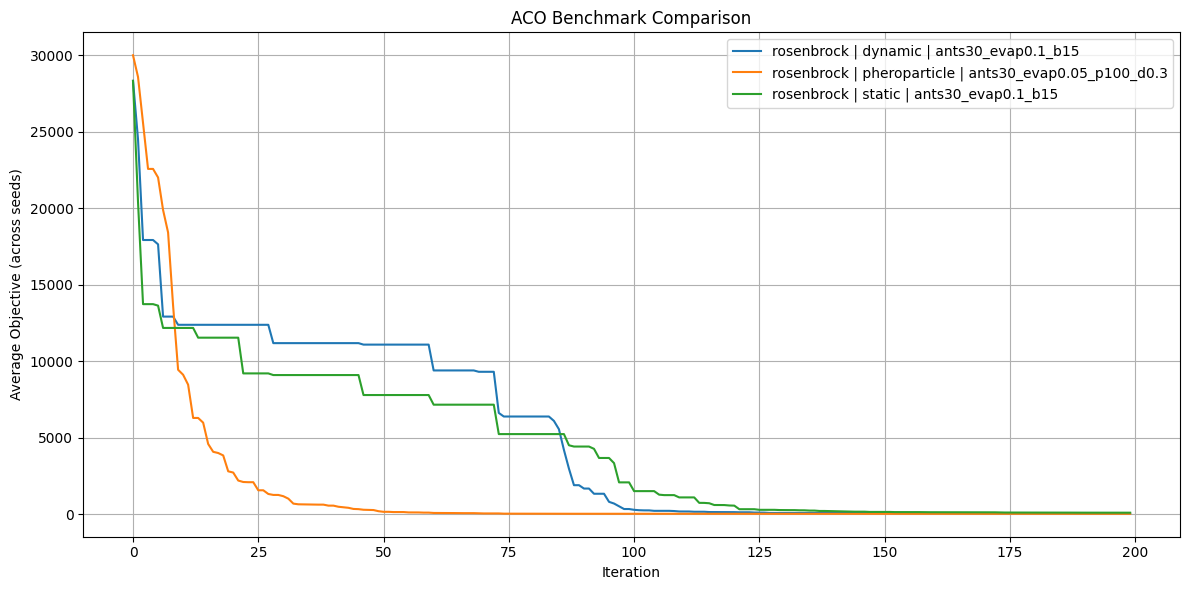

In [142]:
plot_aco_benchmarks(
    methods_to_plot=["static", "dynamic", "pheroparticle"],
    problems_to_plot=["rosenbrock"]
)

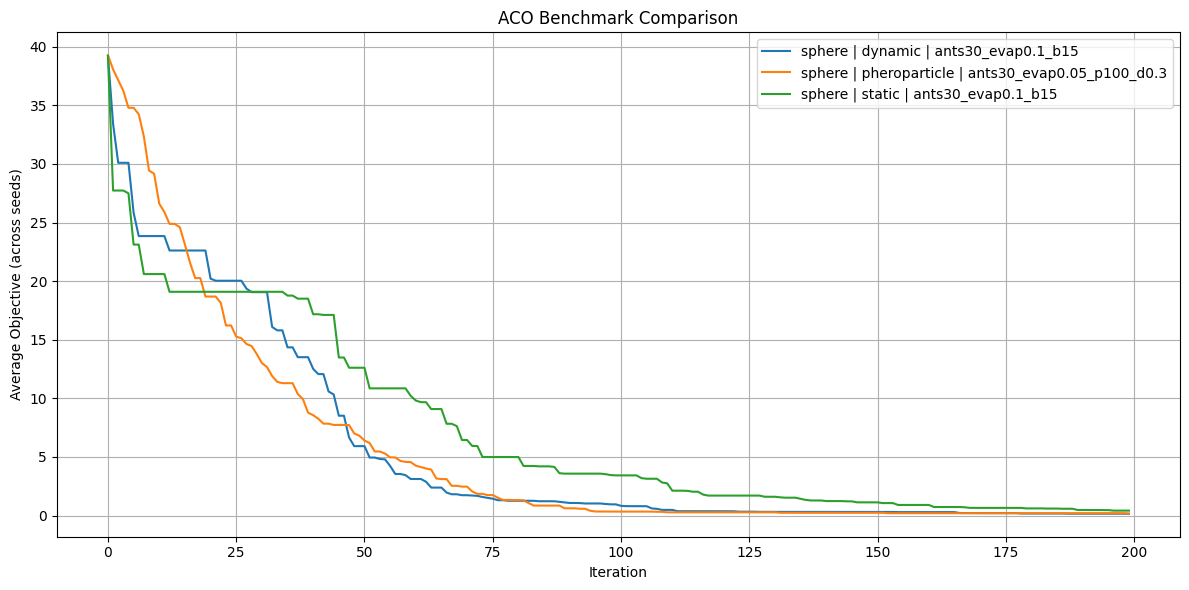

In [143]:
plot_aco_benchmarks(
    methods_to_plot=["static", "dynamic", "pheroparticle"],
    problems_to_plot=["sphere"]
)

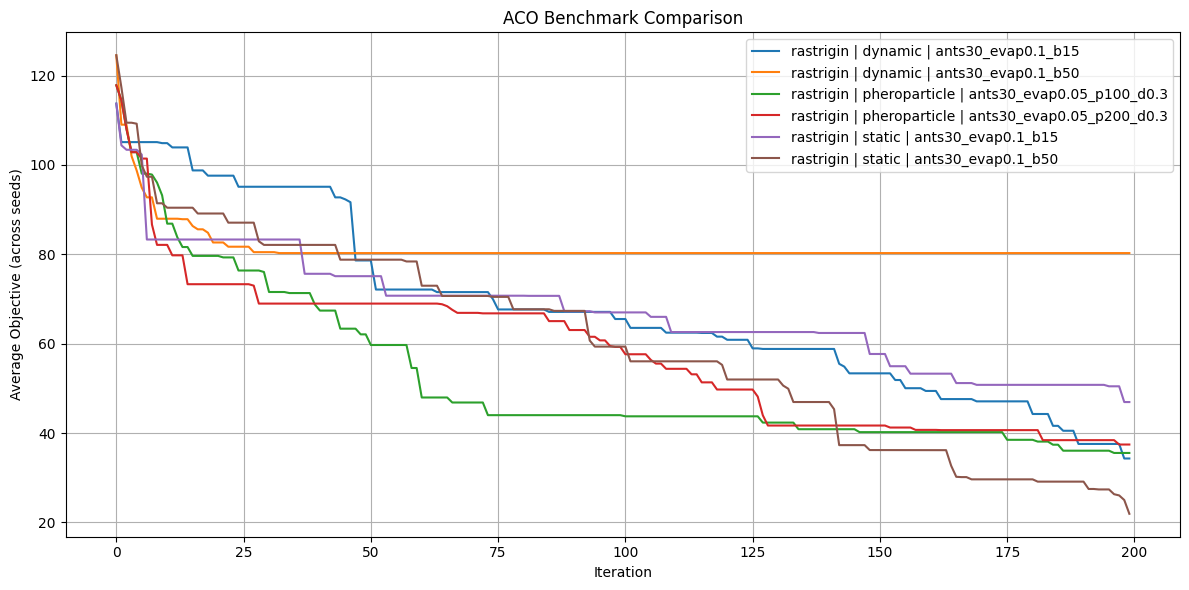

In [144]:
plot_aco_benchmarks(
    methods_to_plot=["static", "dynamic", "pheroparticle"],
    problems_to_plot=["rastrigin"]
)

In [197]:
seeds = [0, 1, 2]
iterations = 300

problem_tab = [
    Rosenbrock(number_of_variables=10),
    Sphere(number_of_variables=10),
    Rastrigin(number_of_variables=10)
]

In [203]:
# no_buckets_tab = [5, 10, 20, 40, 80, 160]
no_pheromones_tab = [5, 10]

In [204]:
for problem in problem_tab:
    for no_pheromones in no_pheromones_tab:
        # benchmark_algorithm(
        #     DynamicBucketingACO,
        #     problem,
        #     method_name="dynamic",
        #     seeds=seeds,
        #     number_of_ants=30,
        #     number_of_buckets=no_buckets,
        #     evaporation_rate=0.1,
        #     iterations=iterations,
        #     output_dir="results"
        # )
        benchmark_algorithm(
            PheromoneParticleACO,
            problem,
            method_name="pheroparticle",
            seeds=seeds,
            number_of_ants=30,
            number_of_pheromones=no_pheromones,
            collapse_distance=0.3,
            evaporation_rate=0.05,
            iterations=iterations,
            output_dir="results"
        )

Running pheroparticle on Rosenbrock (seed=0)...
Running pheroparticle on Rosenbrock (seed=1)...
Running pheroparticle on Rosenbrock (seed=2)...
-----------
Running pheroparticle on Rosenbrock (seed=0)...
Running pheroparticle on Rosenbrock (seed=1)...
Running pheroparticle on Rosenbrock (seed=2)...
-----------
Running pheroparticle on Sphere (seed=0)...
Running pheroparticle on Sphere (seed=1)...
Running pheroparticle on Sphere (seed=2)...
-----------
Running pheroparticle on Sphere (seed=0)...
Running pheroparticle on Sphere (seed=1)...
Running pheroparticle on Sphere (seed=2)...
-----------
Running pheroparticle on Rastrigin (seed=0)...
Running pheroparticle on Rastrigin (seed=1)...
Running pheroparticle on Rastrigin (seed=2)...
-----------
Running pheroparticle on Rastrigin (seed=0)...
Running pheroparticle on Rastrigin (seed=1)...
Running pheroparticle on Rastrigin (seed=2)...
-----------


# Static vs no buckets

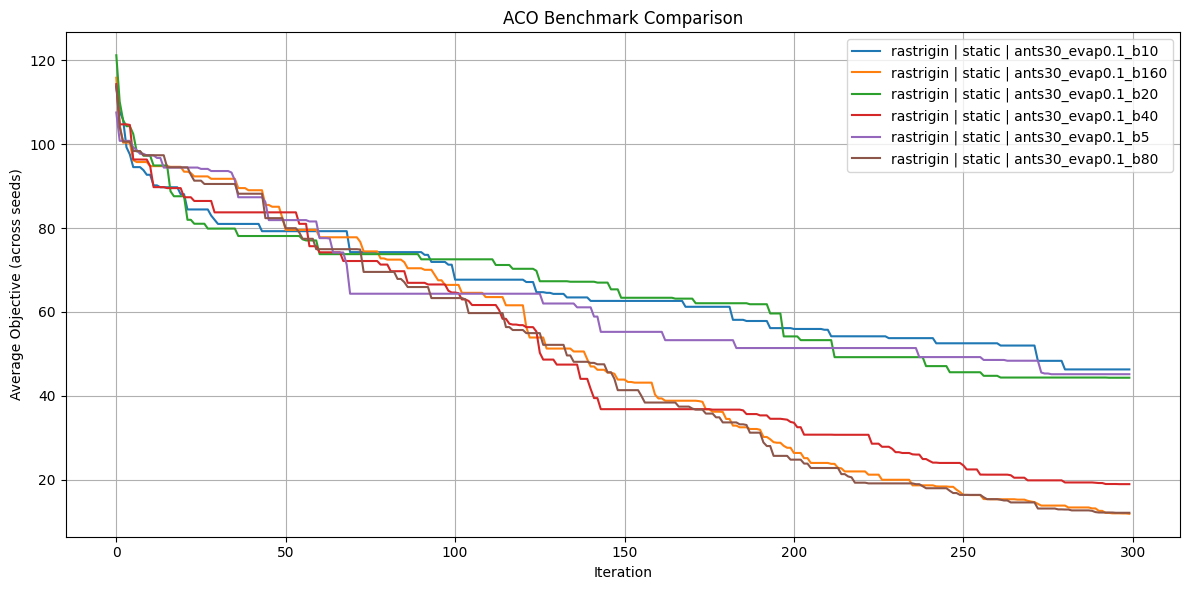

In [174]:
plot_aco_benchmarks(
    methods_to_plot=["static"],
    problems_to_plot=["rastrigin"]
)

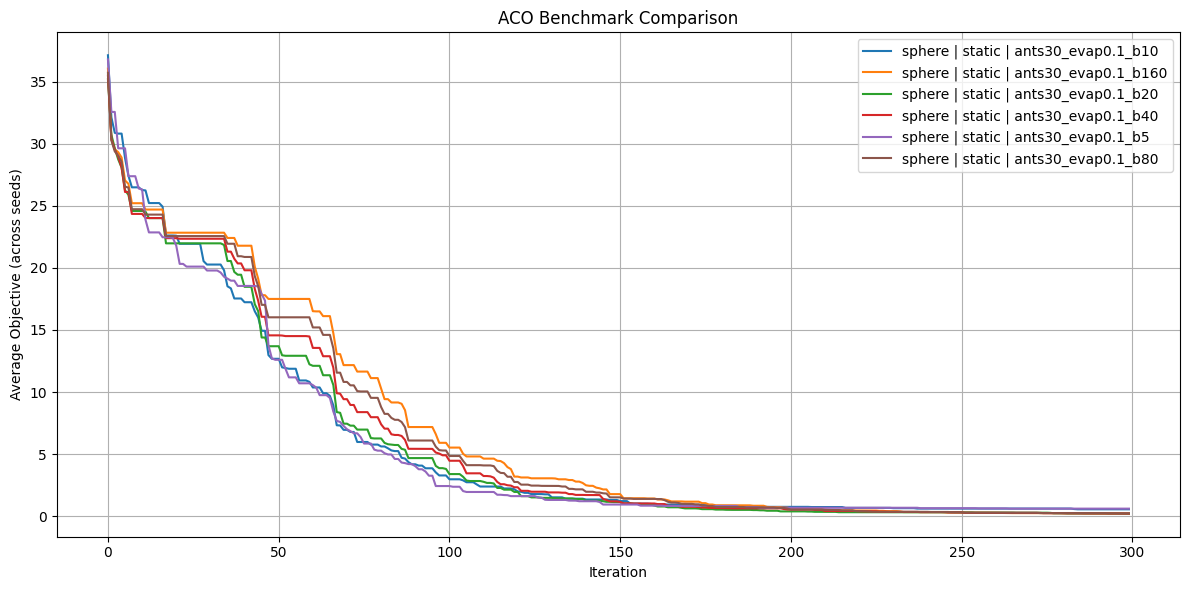

In [175]:
plot_aco_benchmarks(
    methods_to_plot=["static"],
    problems_to_plot=["sphere"]
)

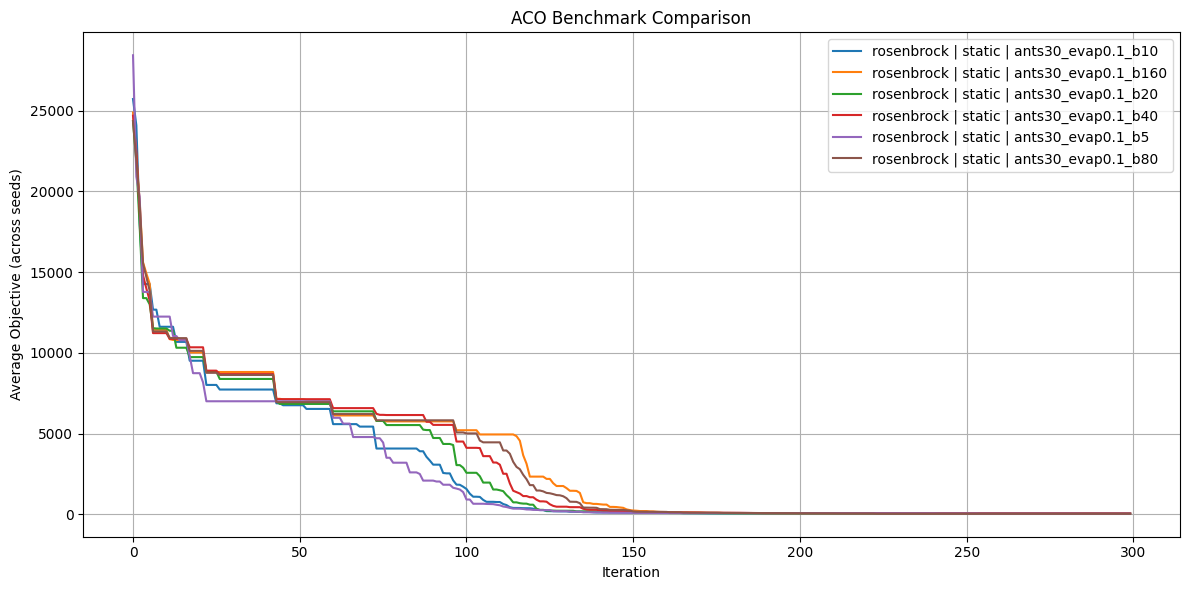

In [176]:
plot_aco_benchmarks(
    methods_to_plot=["static"],
    problems_to_plot=["rosenbrock"]
)

# Dynamic vs no_buckets

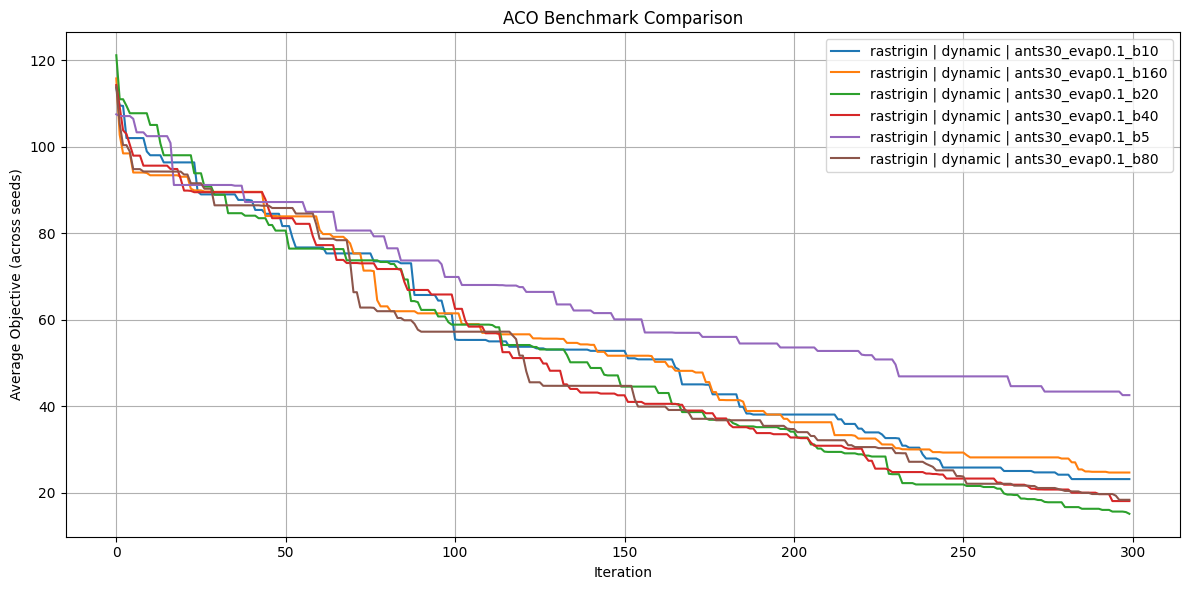

In [190]:
plot_aco_benchmarks(
    methods_to_plot=["dynamic"],
    problems_to_plot=["rastrigin"]
)

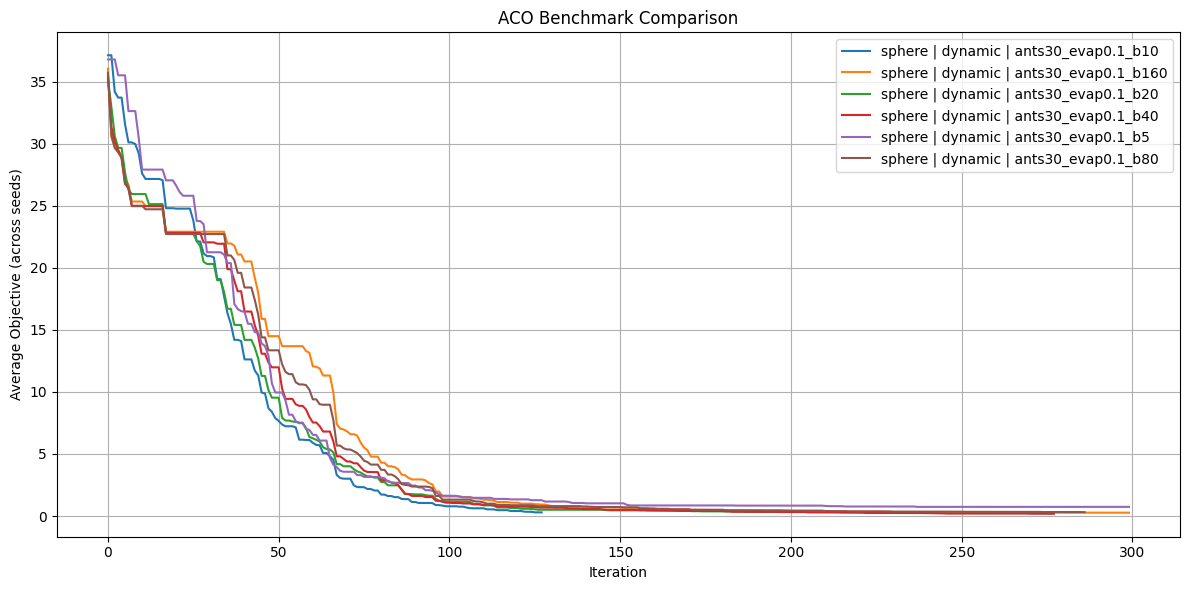

In [191]:
plot_aco_benchmarks(
    methods_to_plot=["dynamic"],
    problems_to_plot=["sphere"]
)

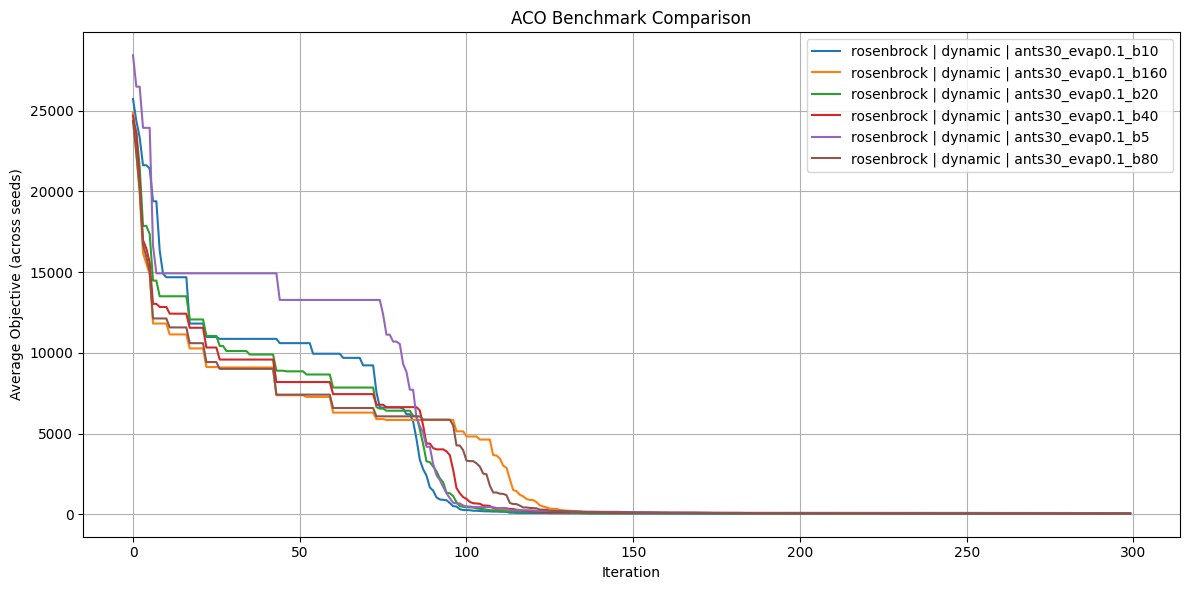

In [193]:
plot_aco_benchmarks(
    methods_to_plot=["dynamic"],
    problems_to_plot=["rosenbrock"]
)

# particle vs no particles

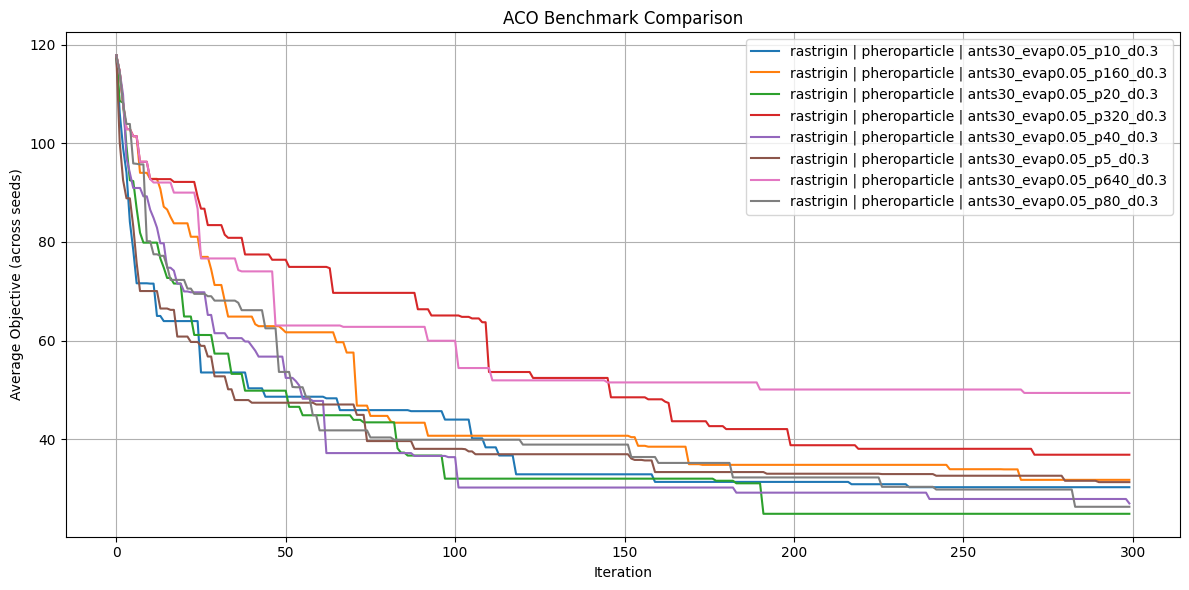

In [205]:
plot_aco_benchmarks(
    methods_to_plot=["pheroparticle"],
    problems_to_plot=["rastrigin"]
)

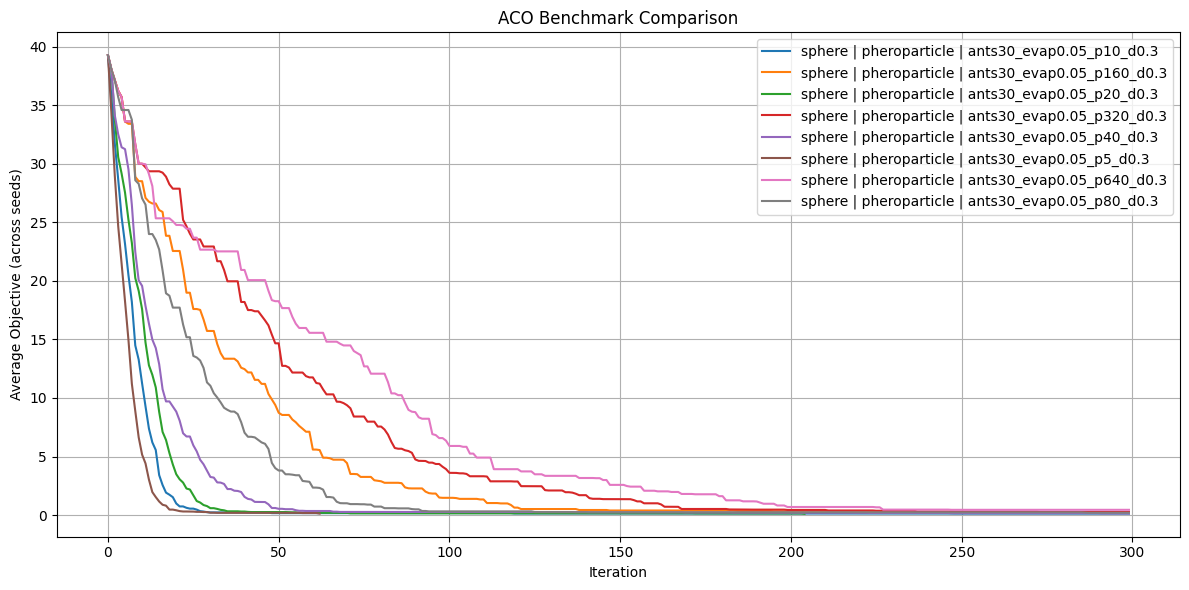

In [206]:
plot_aco_benchmarks(
    methods_to_plot=["pheroparticle"],
    problems_to_plot=["sphere"]
)

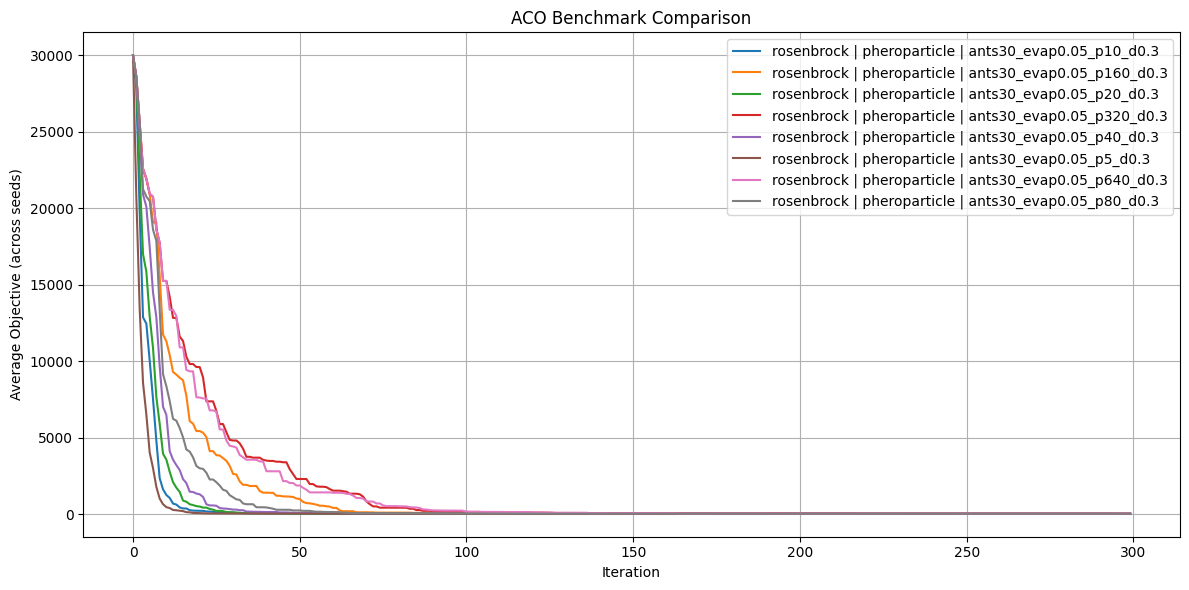

In [207]:
plot_aco_benchmarks(
    methods_to_plot=["pheroparticle"],
    problems_to_plot=["rosenbrock"]
)

In [192]:
seeds = [0, 1, 2]
iterations = 300

problem_tab = [
    Rosenbrock(number_of_variables=10),
    Sphere(number_of_variables=10),
    Rastrigin(number_of_variables=10)
]

In [186]:
no_ants_tab = [5, 10, 20, 40, 80, 160]

In [ ]:
for problem in problem_tab:
    for no_ants in no_ants_tab:
        benchmark_algorithm(
            StaticBucketingACO,
            problem,
            method_name="static",
            seeds=seeds,
            number_of_ants=no_ants,
            number_of_buckets=80,
            evaporation_rate=0.1,
            iterations=iterations,
            output_dir="results"
        )